Importing libraries


In [545]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from imblearn.over_sampling import SVMSMOTE
from sklearn.model_selection import train_test_split,learning_curve,GridSearchCV,RandomizedSearchCV,cross_val_score
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score,silhouette_score,ConfusionMatrixDisplay,classification_report,roc_auc_score,roc_curve,precision_recall_curve,confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler,StandardScaler,LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import LocalOutlierFactor,NearestNeighbors,KNeighborsClassifier
from sklearn.cluster import KMeans,AgglomerativeClustering,DBSCAN
from yellowbrick.cluster import KElbowVisualizer
import plotly.graph_objs as go
import plotly as py
import plotly.io as pio
import plotly.figure_factory as ff
import plotly.express as px
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import gradio as gr
import scipy.cluster.hierarchy as shc
import graphviz
import time
import warnings
import pickle

init_notebook_mode(connected=True)
warnings.filterwarnings('ignore')

Reading File

In [528]:
file="predictive_maintenance.csv"
data=pd.read_csv(file)
df=pd.DataFrame(data)
print(df.columns)
print(df.head(10))

Index(['UDI', 'Product ID', 'Type', 'Air temperature [K]',
       'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]',
       'Tool wear [min]', 'Target', 'Failure Type'],
      dtype='object')
   UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
0    1     M14860    M                298.1                    308.6   
1    2     L47181    L                298.2                    308.7   
2    3     L47182    L                298.1                    308.5   
3    4     L47183    L                298.2                    308.6   
4    5     L47184    L                298.2                    308.7   
5    6     M14865    M                298.1                    308.6   
6    7     L47186    L                298.1                    308.6   
7    8     L47187    L                298.1                    308.6   
8    9     M14868    M                298.3                    308.7   
9   10     M14869    M                298.5                    309.0   

Data Pre-Processing

In [529]:
df.rename(mapper={'Air temperature [K]':'Air temperature','Process temperature [K]':'Process temperature',
                  'Rotational speed [rpm]':'Rotational speed','Torque [Nm]':'Torque','Tool wear [min]':'Tool wear'},axis=1,inplace=True)

In [530]:
df.drop(["UDI","Product ID"],axis=1,inplace=True)

In [531]:
df=pd.get_dummies(df,columns=["Failure Type"])

In [532]:
df.rename(mapper={'Failure Type_Heat Dissipation Failure':'HDF', 'Failure Type_No Failure':'Failure',
       'Failure Type_Overstrain Failure':'OSF', 'Failure Type_Power Failure':'PWF',
       'Failure Type_Random Failures':'RNF', 'Failure Type_Tool Wear Failure':'TWF'},axis=1,inplace=True)

In [533]:
df['Failure'] = df['Failure'].apply(lambda x: True if x == 0 else False)

In [534]:
df['Target'] = df['Target'].apply(lambda x: True if x == 1 else False)

In [535]:
df = df[['Type', 'Air temperature', 'Process temperature', 'Rotational speed',
       'Torque', 'Tool wear', 'Target','Failure', 'HDF',  'OSF', 'PWF', 'RNF',
       'TWF']] #sorting columns

Plotting Graphics

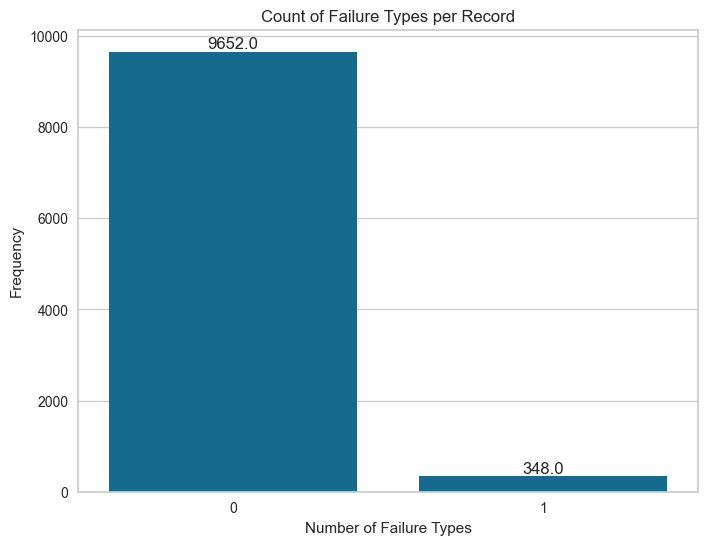

In [536]:
df_failures = df[['HDF', 'OSF', 'PWF', 'RNF', 'TWF']]

rows_sum = df_failures.sum(axis=1)

plt.figure(figsize=(8, 6))
ax = sns.countplot(x=rows_sum)
for patch in ax.patches:
    ax.annotate(str(patch.get_height()), (patch.get_x() + patch.get_width()/2, patch.get_height()), ha='center', va='bottom')
plt.title('Count of Failure Types per Record')
plt.xlabel('Number of Failure Types')
plt.ylabel('Frequency')
plt.show()

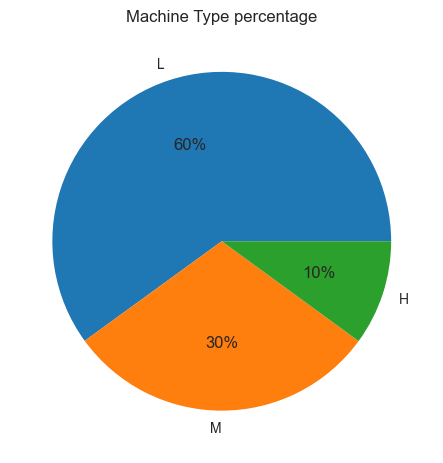

In [537]:
value = df['Type'].value_counts()
Type_percentage = 100*value/df.Type.shape[0]
labels = Type_percentage.index.array
x = Type_percentage.array
plt.pie(x, labels = labels, colors=sns.color_palette('tab10')[0:3], autopct='%.0f%%')
plt.title('Machine Type percentage')
plt.show()

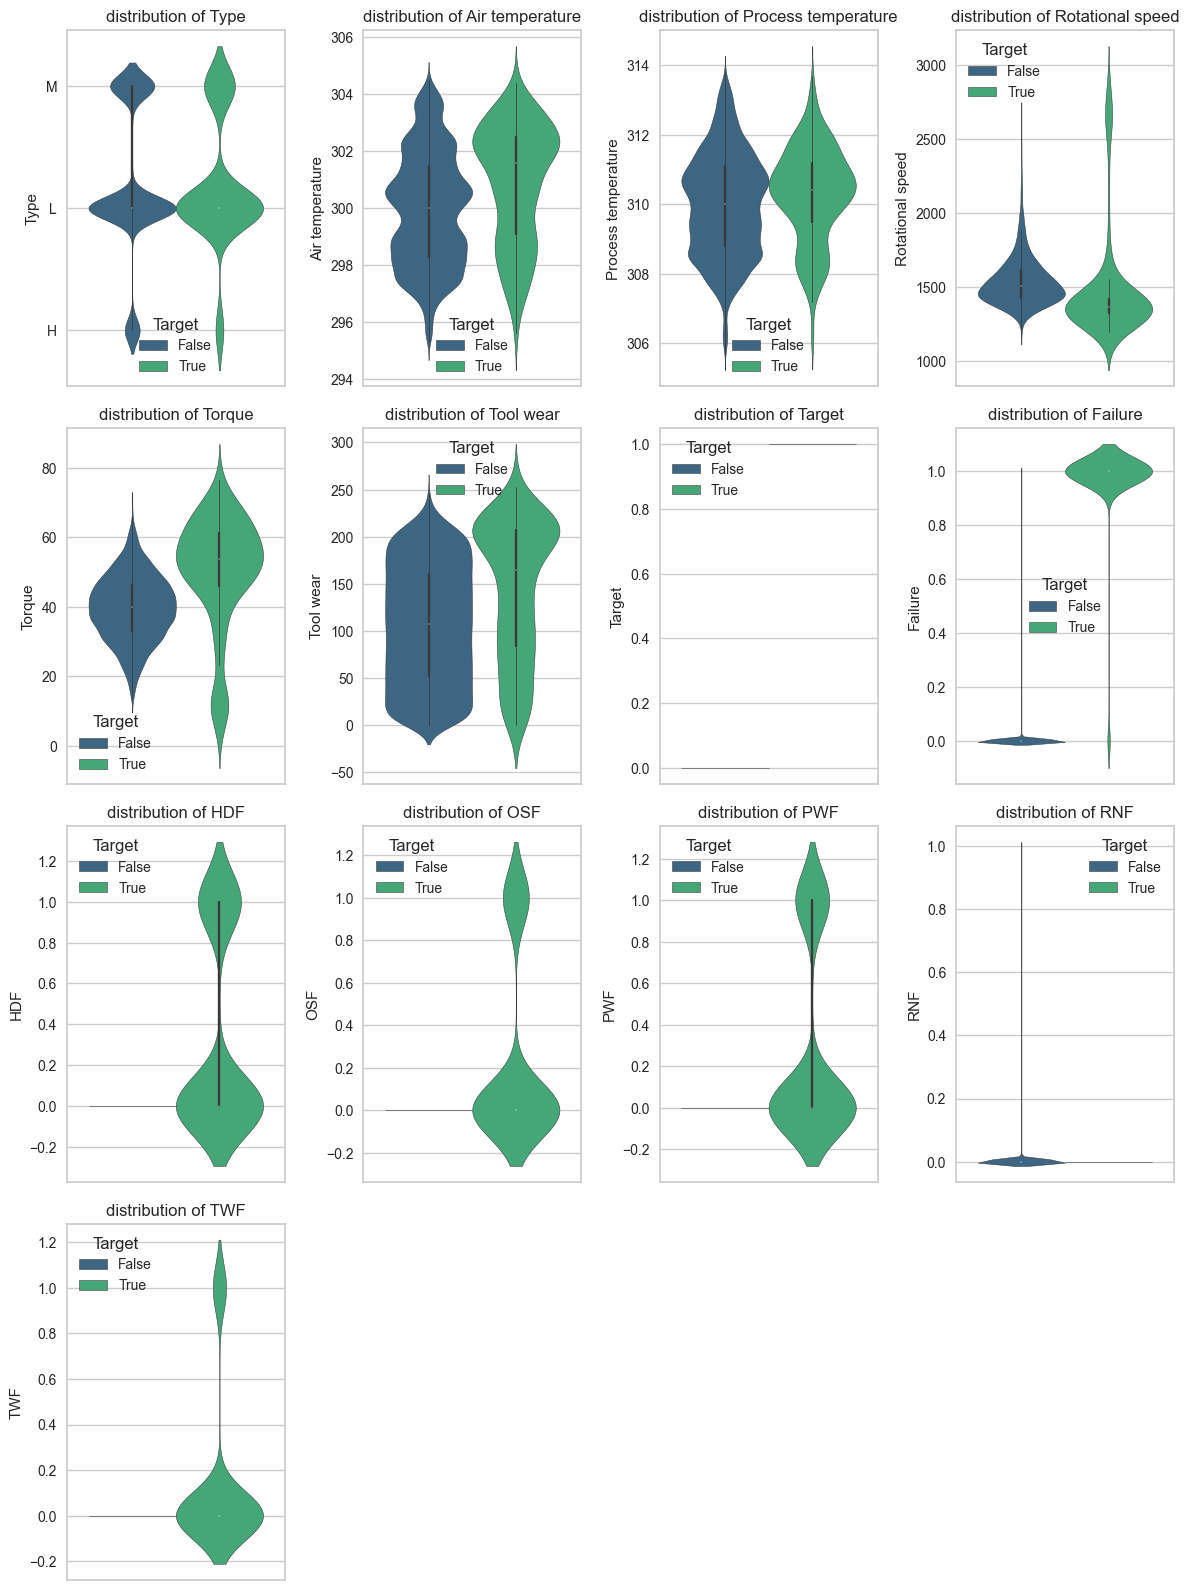

In [544]:

num_features = len(df.columns)
num_rows = (num_features + 1) // 2  
num_cols = 4 

plt.figure(figsize=(12, num_rows * 4))  
for i, column in enumerate(df.columns, 1):
    plt.subplot(num_rows, num_cols, i)
    sns.violinplot(y=column, data=df, palette='viridis',hue='Target')
    plt.title(f'distribution of {column}')

plt.tight_layout()
plt.show()


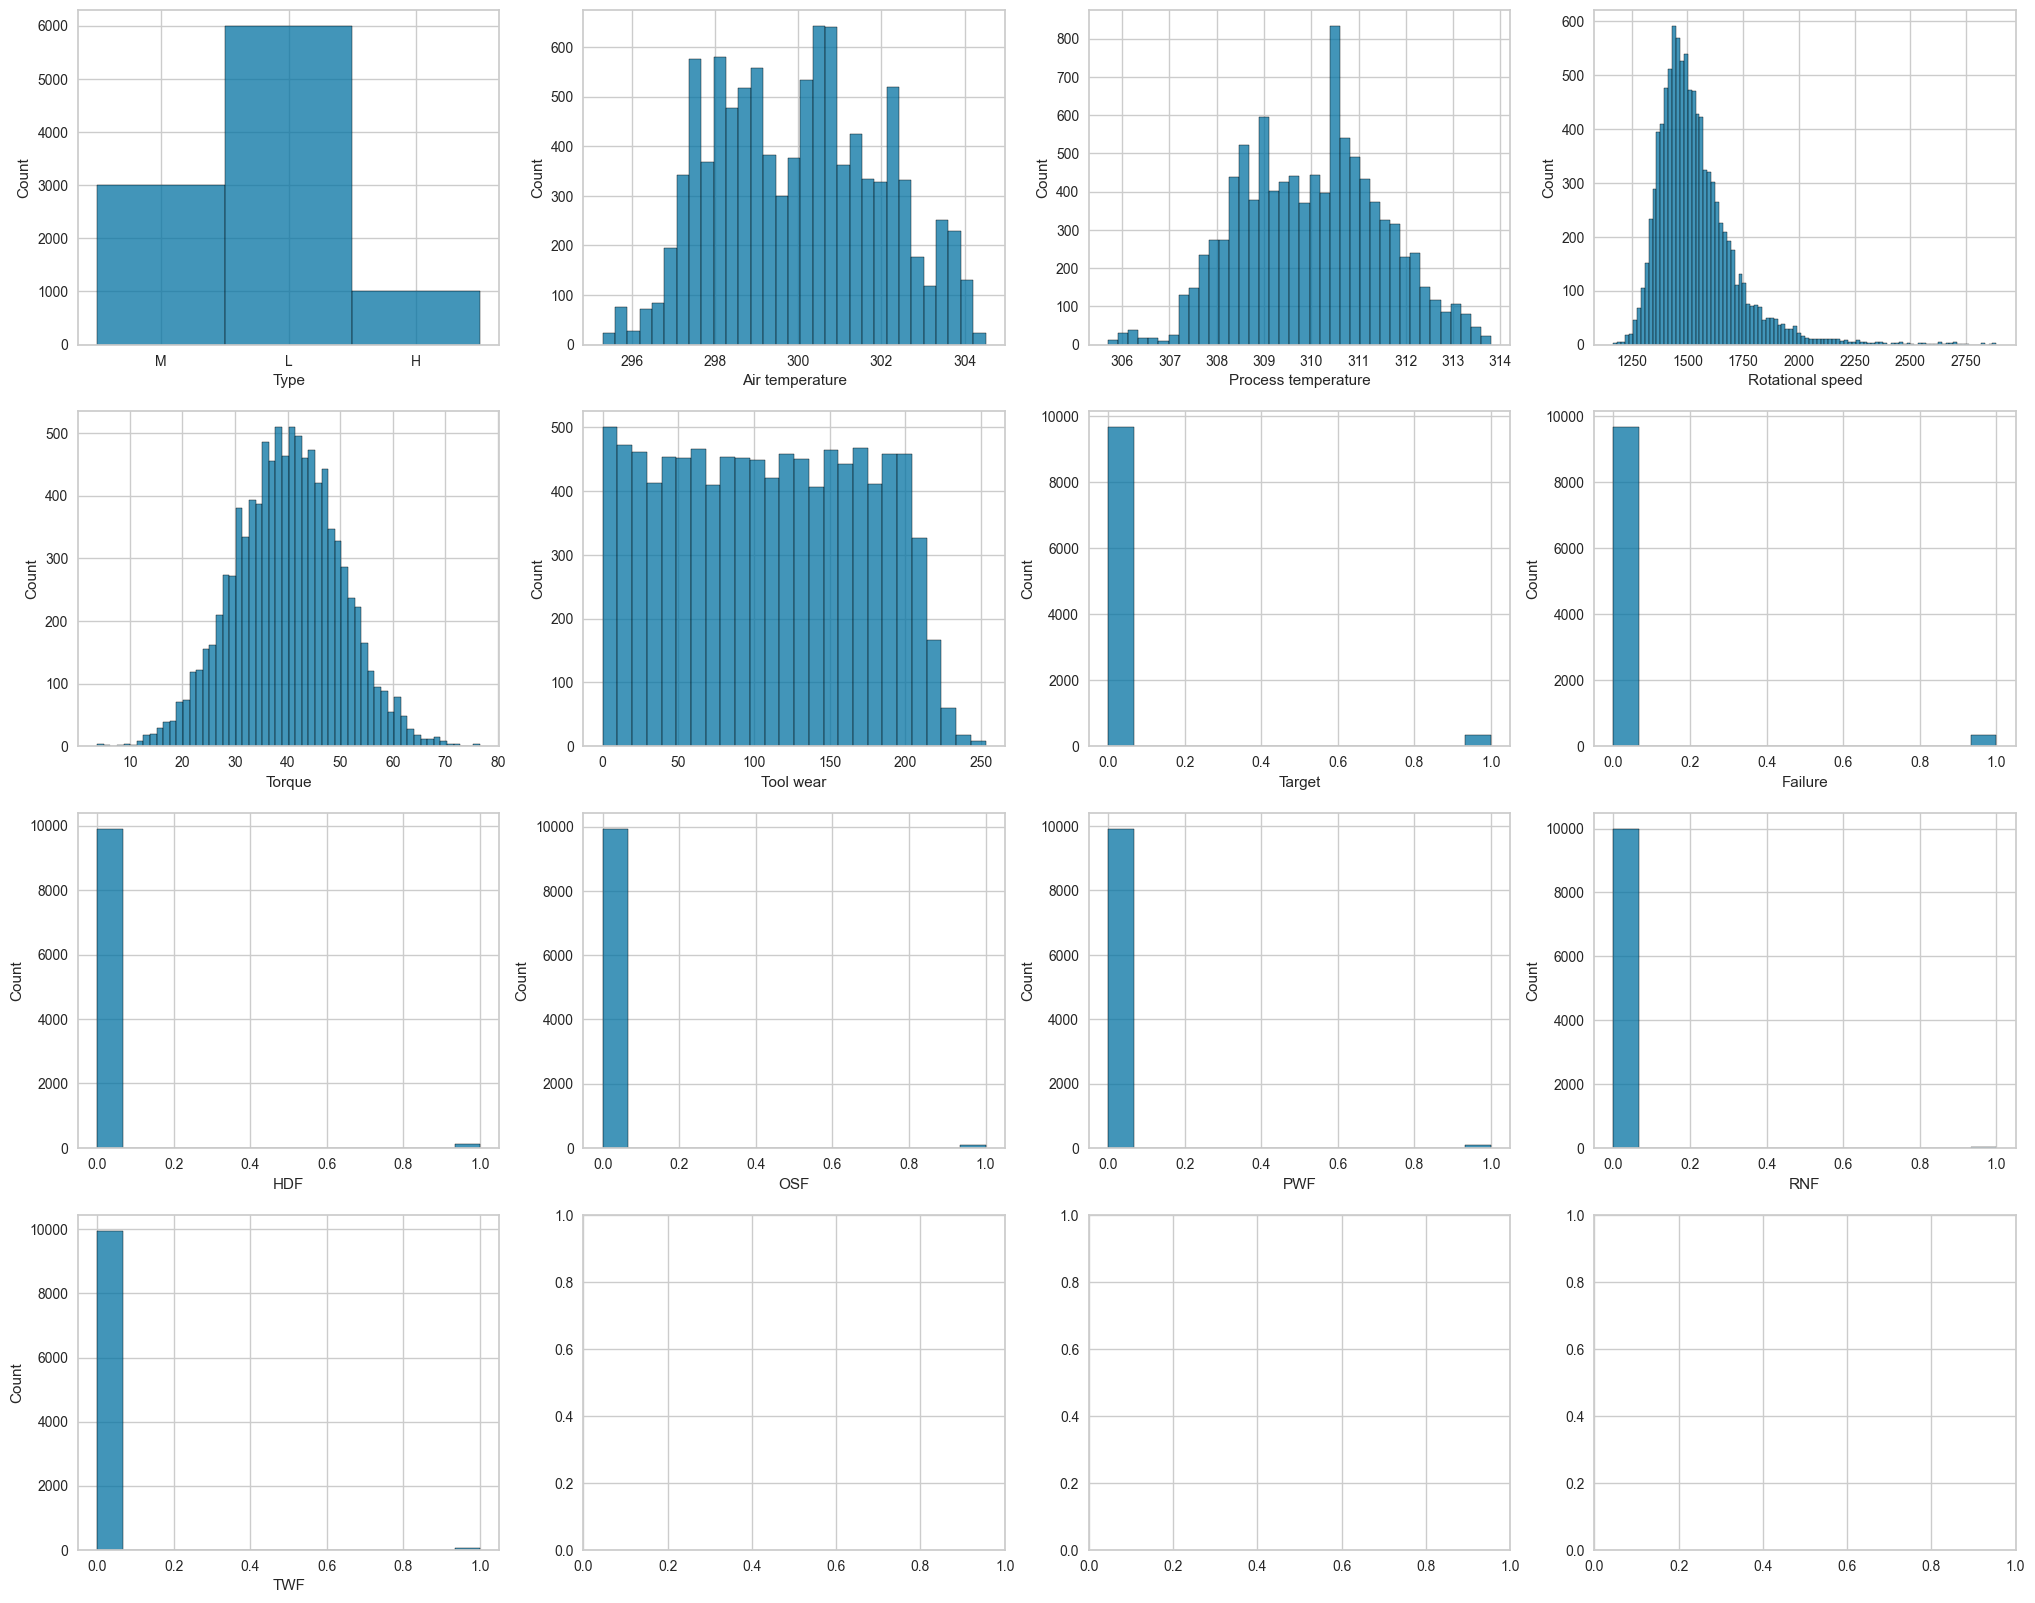

In [432]:
fig, ax = plt.subplots(4, 4, figsize=(25, 20))

for i, col in enumerate(df.columns):
    sns.histplot(df[col], ax=ax[i//4][i%4])

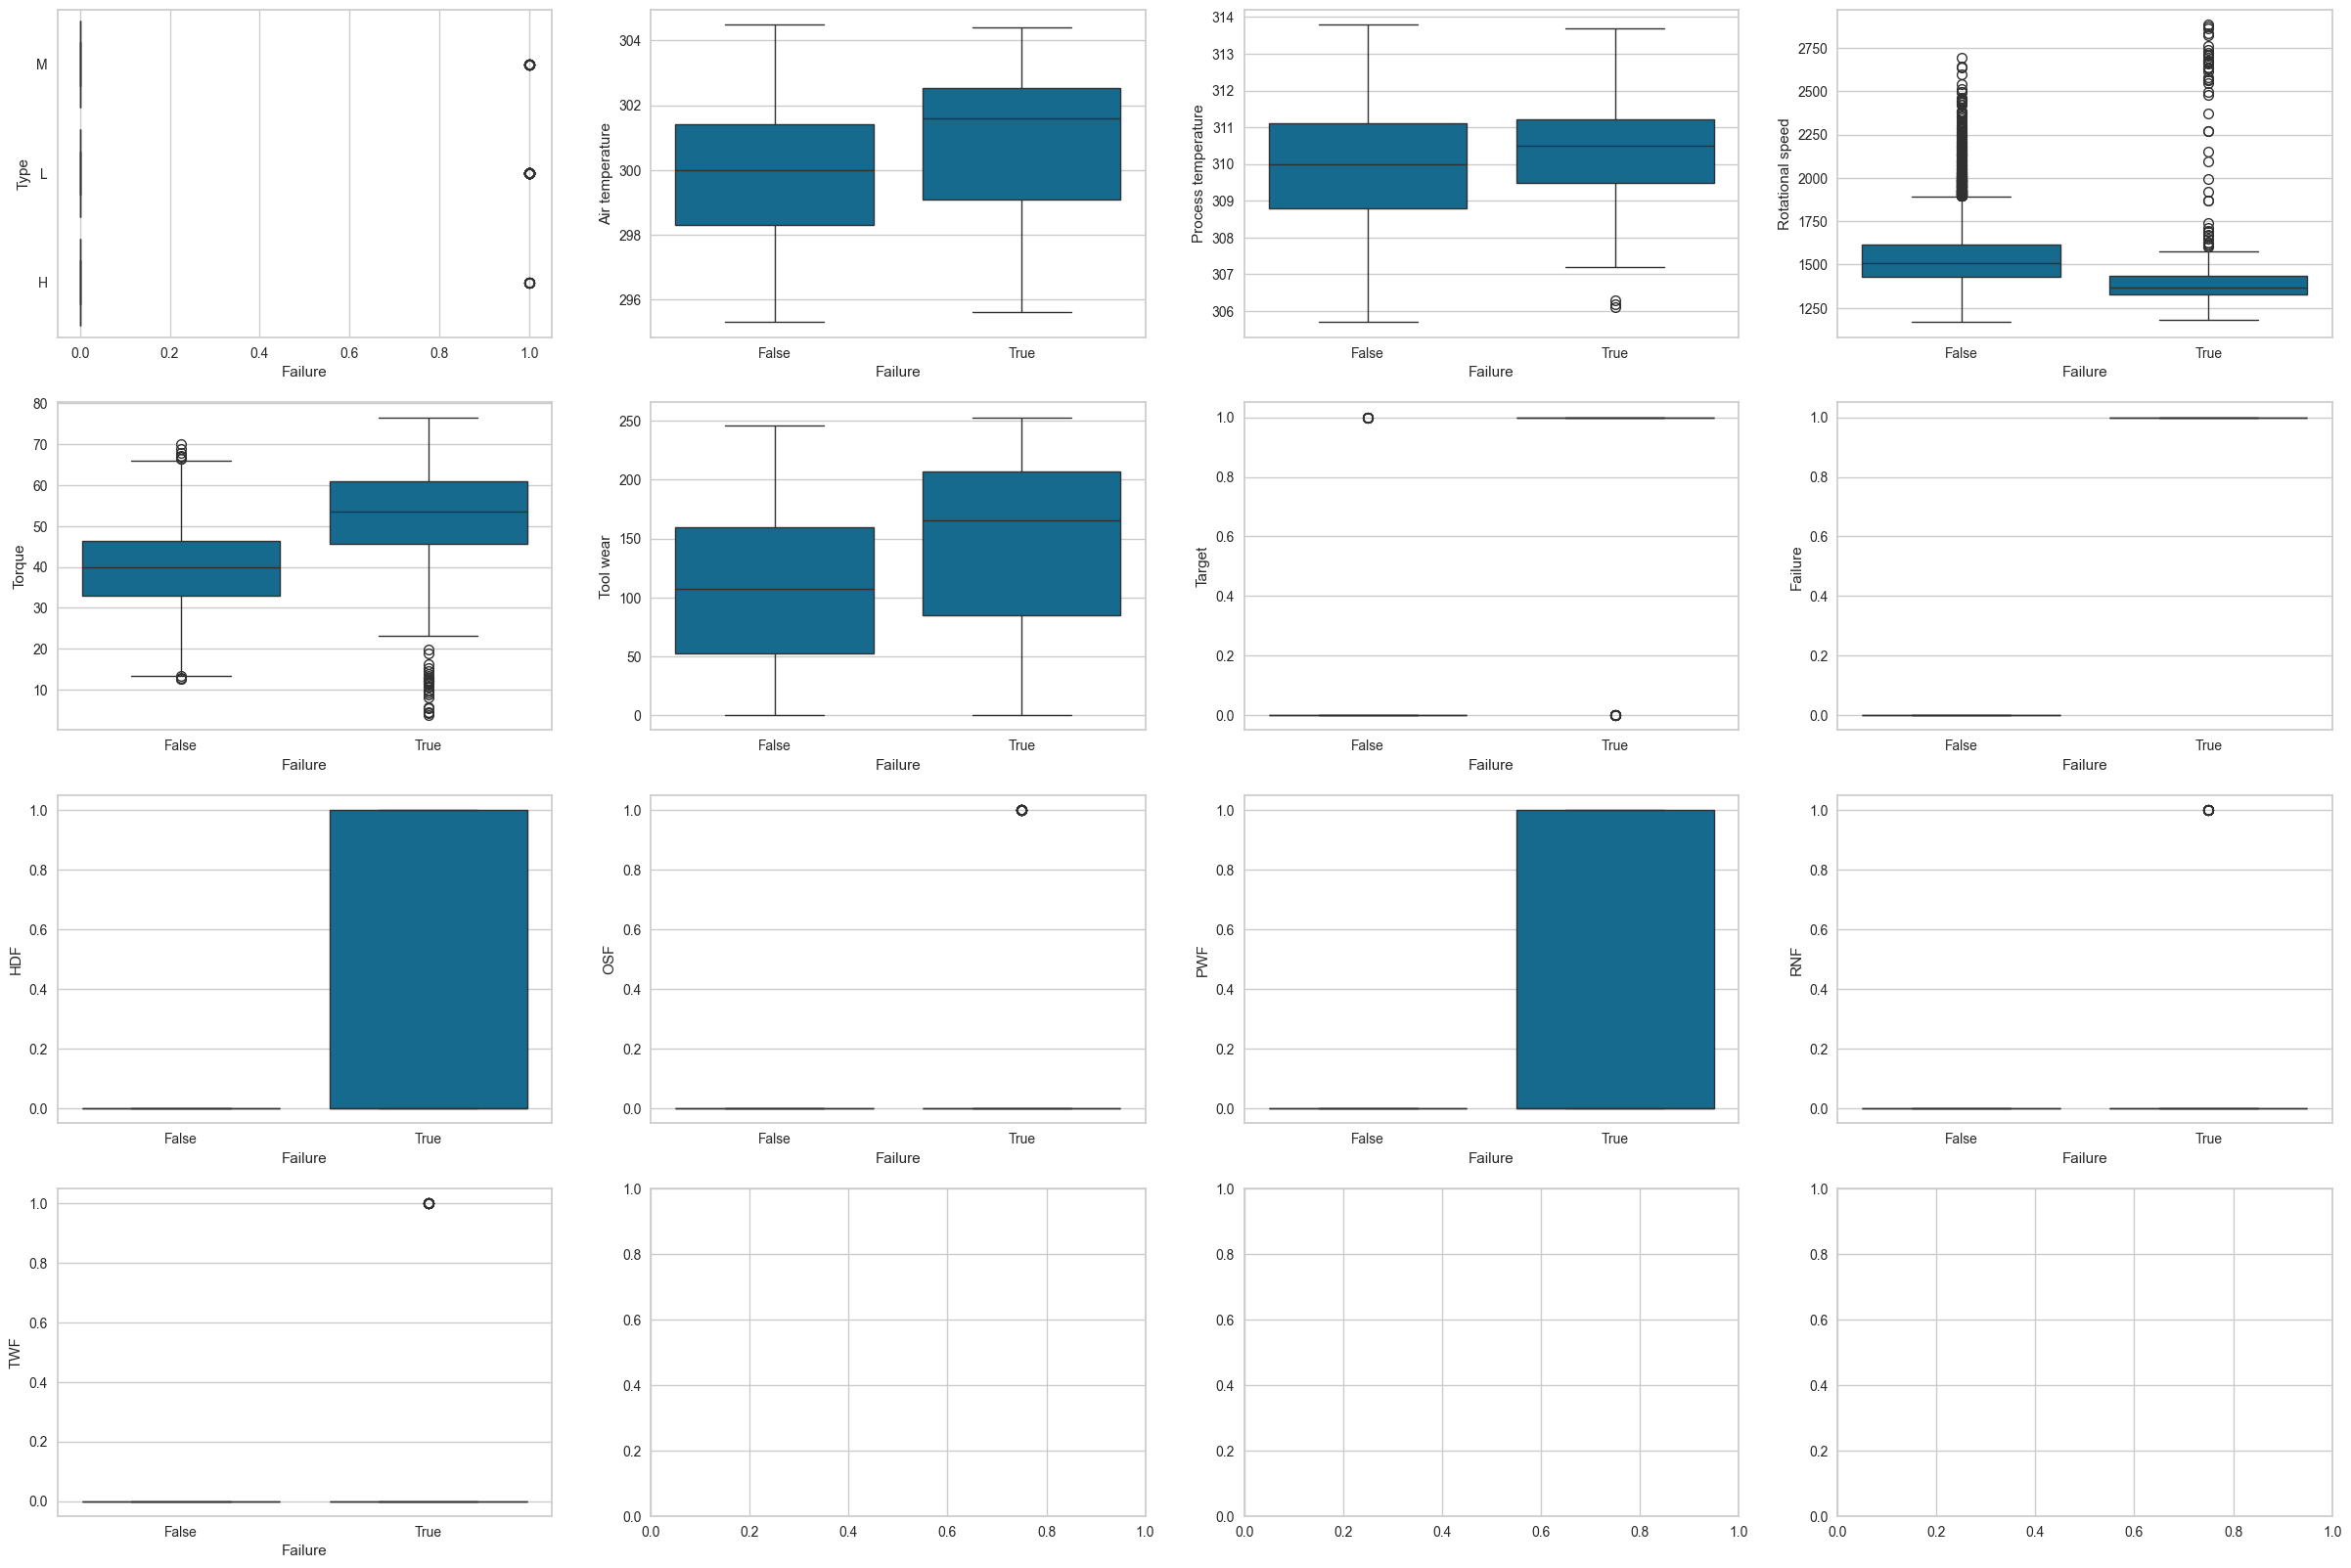

In [433]:
fig, ax = plt.subplots(4, 4, figsize=(30, 20))
for i, col in enumerate(df.columns):
    sns.boxplot(x="Failure", y=col, data=df, ax=ax[i//4][i%4])

Label Encoding

In [434]:
df['Failure']=0
df['Failure'][df['HDF']==1]=1
df['Failure'][df['OSF']==1]=2
df['Failure'][df['PWF']==1]=3
df['Failure'][df['RNF']==1]=4
df['Failure'][df['TWF']==1]=5

In [435]:
le=LabelEncoder()
le.fit(df['Type'])
df['Type']=le.transform(df['Type'])
print(le.classes_) 
print(df['Type']) 

['H' 'L' 'M']
0       2
1       1
2       1
3       1
4       1
       ..
9995    2
9996    0
9997    2
9998    0
9999    2
Name: Type, Length: 10000, dtype: int64


In [436]:
df.drop(['HDF', 'OSF', 'PWF', 'RNF', 'TWF'],axis=1,inplace=True)

Pair Plot and Corrolation Matrix

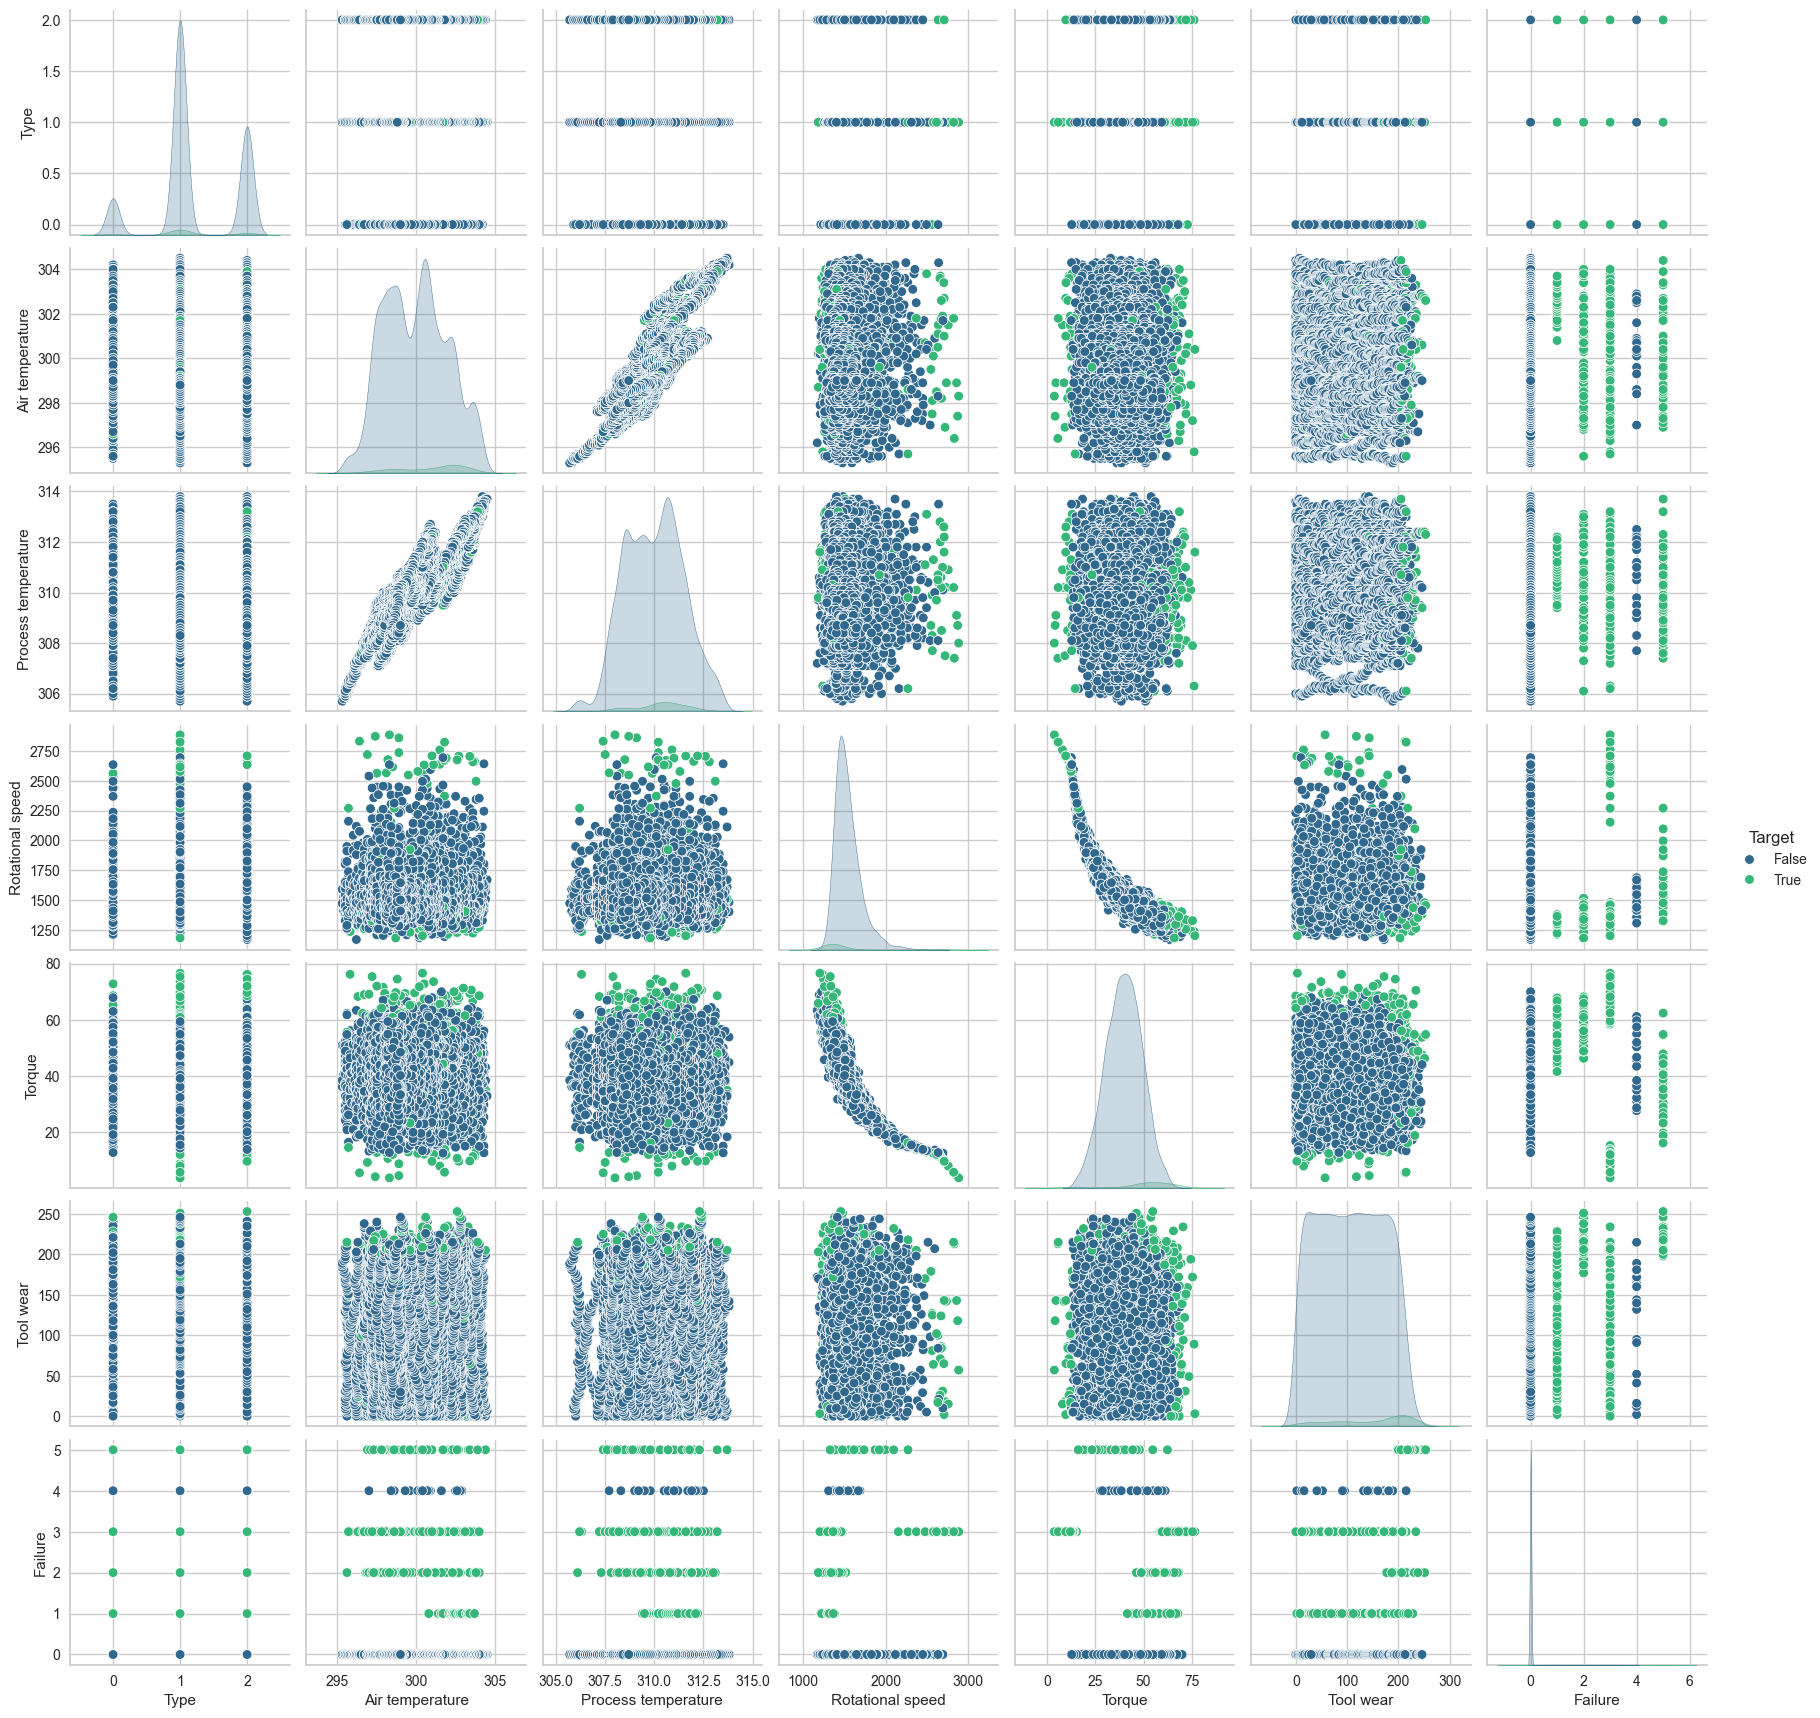

In [437]:
sns.pairplot(df, hue='Target',palette='viridis')

<Axes: >

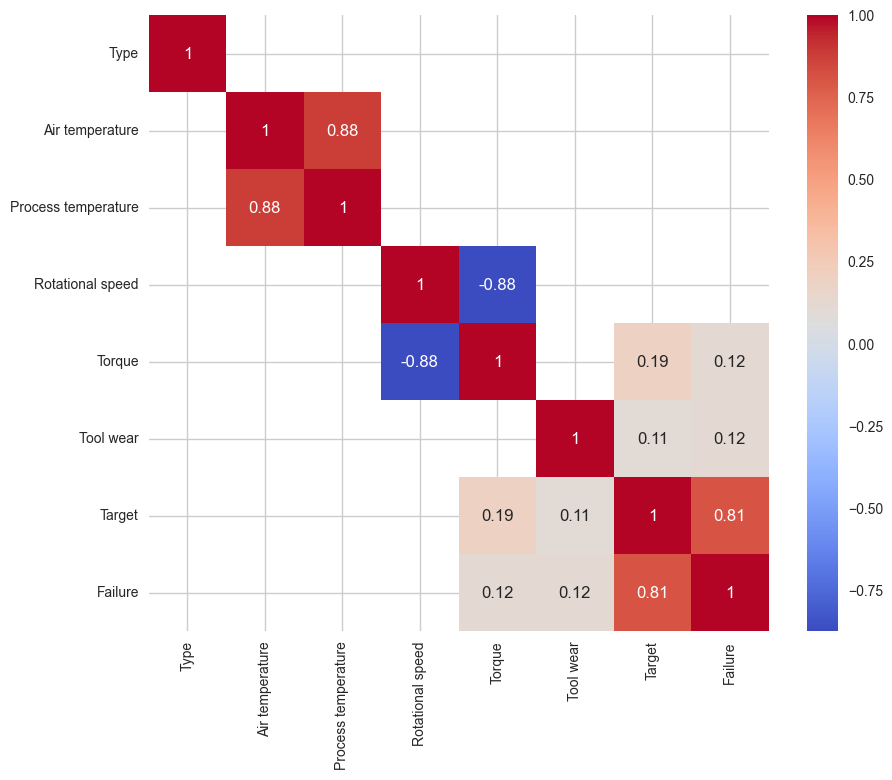

In [438]:
threshold = 0.1
correlation = df.corr()
matrix = correlation.where((abs(correlation) >= threshold)).isna()
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), cmap="coolwarm", annot=True, mask=matrix)

In [439]:
df.head()

Type  Air temperature  Process temperature  Rotational speed  Torque  \
0     2            298.1                308.6              1551    42.8   
1     1            298.2                308.7              1408    46.3   
2     1            298.1                308.5              1498    49.4   
3     1            298.2                308.6              1433    39.5   
4     1            298.2                308.7              1408    40.0   

   Tool wear  Target  Failure  
0          0   False        0  
1          3   False        0  
2          5   False        0  
3          7   False        0  
4          9   False        0

Defining Outliers

In [440]:
excluded_columns = ['Failure']

model = LocalOutlierFactor(n_neighbors=5)

scores = model.fit_predict(df)

outliers = df[scores == -1]
if not outliers.empty:
    df.drop(outliers.index, inplace=True)

In [441]:
df.shape

(9937, 8)

In [442]:
df.drop('Type',axis=1,inplace=True)

Pie Chart of Output

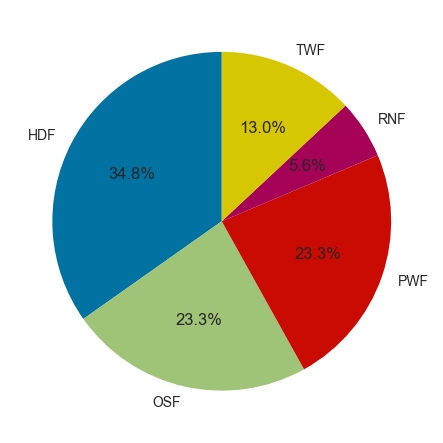

In [443]:
df_fail= df[df['Failure']!=0]
df_fail_dist= df_fail.groupby('Failure').size()
plt.pie(df_fail_dist, labels=['HDF', 'OSF', 'PWF', 'RNF', 'TWF'], autopct='%1.1f%%', startangle=90)
plt.show()

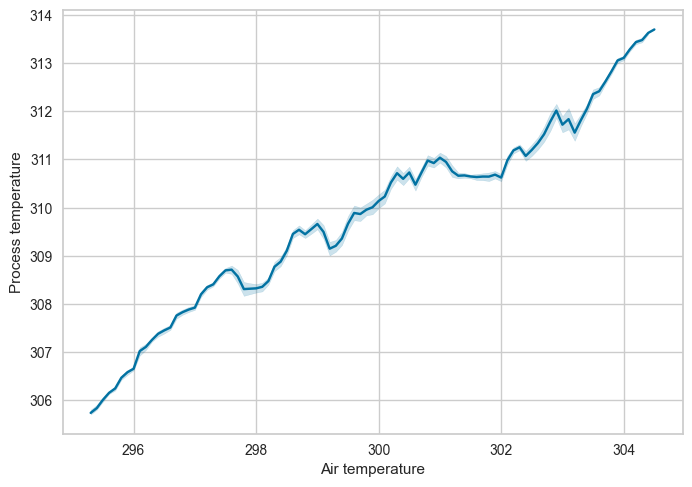

In [444]:
sns.lineplot(x="Air temperature",y="Process temperature",data=df)   
plt.show()

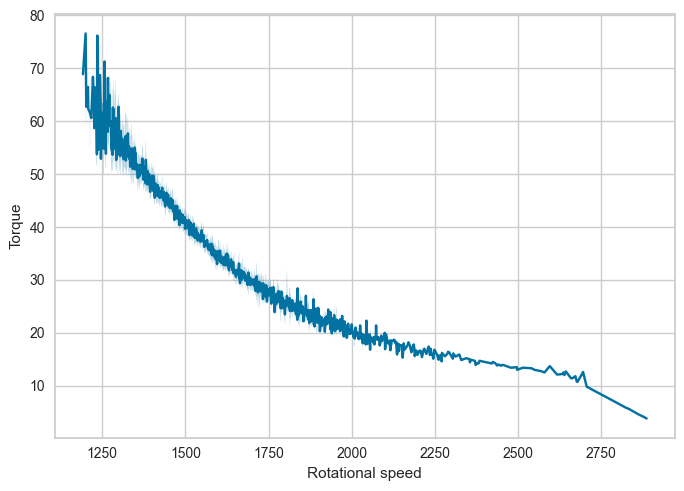

In [445]:
sns.lineplot(x="Rotational speed",y="Torque",data=df)   
plt.show()

In [446]:
line2=go.Scatter(x=df['Air temperature'],
                  y=df['Process temperature'],
                    mode='lines+markers', 
                    name='Air temperature/Process temperature',
                    text=df['Air temperature'])

layouts=go.Layout(title='Comparison of Torque/Rotational speed and Air temperature/Process temperature',
                 xaxis=dict(title='Value'),
                 yaxis=dict(title='Value'),
                 showlegend=True)
fig=dict(data=line2, layout=layouts)
plot(fig,filename="outputs.html")
iplot(fig)

Unsupervised Models

K-Means Clustering

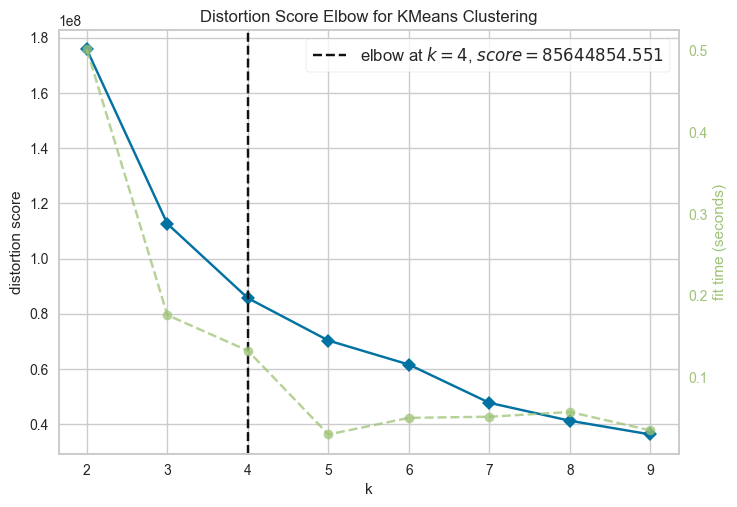

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [447]:
X=df[['Air temperature','Process temperature','Rotational speed','Torque','Tool wear']]

model = KMeans()

visualizer = KElbowVisualizer(model, k=(2,10)) # it turns out that k = 4 is the optimal number of clusters 

visualizer.fit(X)
visualizer.show()

In [448]:
kmeans = KMeans(init="random",  n_clusters=4,
                n_init=10, max_iter=300, random_state=42)
kmeans.fit(X)

df["kmeans_cluster"] = kmeans.predict(X)

<Figure size 1000x800 with 0 Axes>

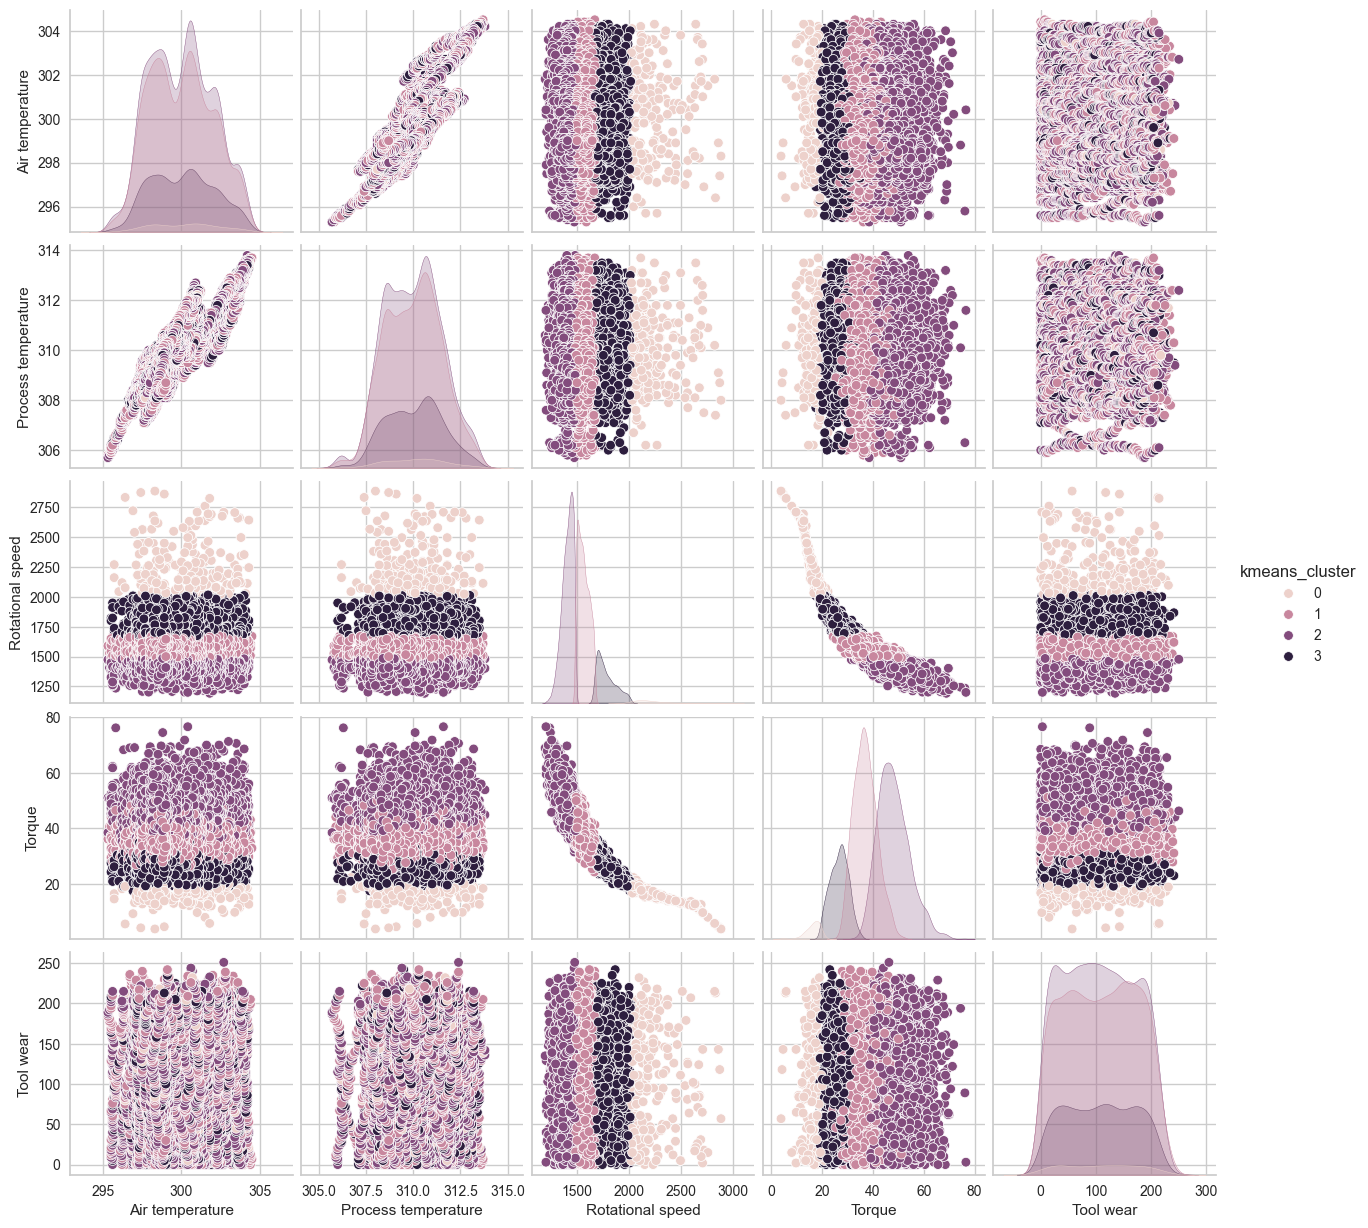

In [449]:
plt.figure(figsize=(10, 8))

# create a pairplot of the data, colored by cluster label
sns.pairplot(df, hue="kmeans_cluster", vars=["Air temperature", "Process temperature", "Rotational speed", "Torque", "Tool wear"])
plt.show()

In [450]:
score = silhouette_score(X, kmeans.predict(X))

print(f"Silhouette Coefficient: {score:.3f}")

Silhouette Coefficient: 0.372


Hierarchical clustering

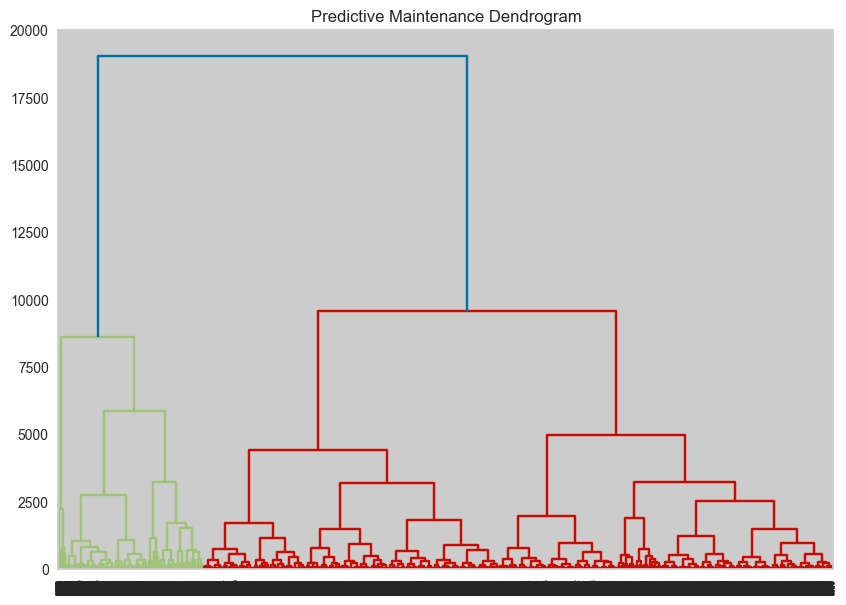

In [451]:
#dendogram
plt.figure(figsize=(10, 7))
plt.title("Predictive Maintenance Dendrogram")

clusters = shc.linkage(X, method='ward', metric="euclidean")
shc.dendrogram(Z=clusters)
plt.show()

In [452]:
# Hierarchical clustering
model = AgglomerativeClustering(n_clusters=3, metric='euclidean', linkage='ward')
model.fit(X)
df["hierarchical_cluster"] = model.labels_

<Figure size 1000x800 with 0 Axes>

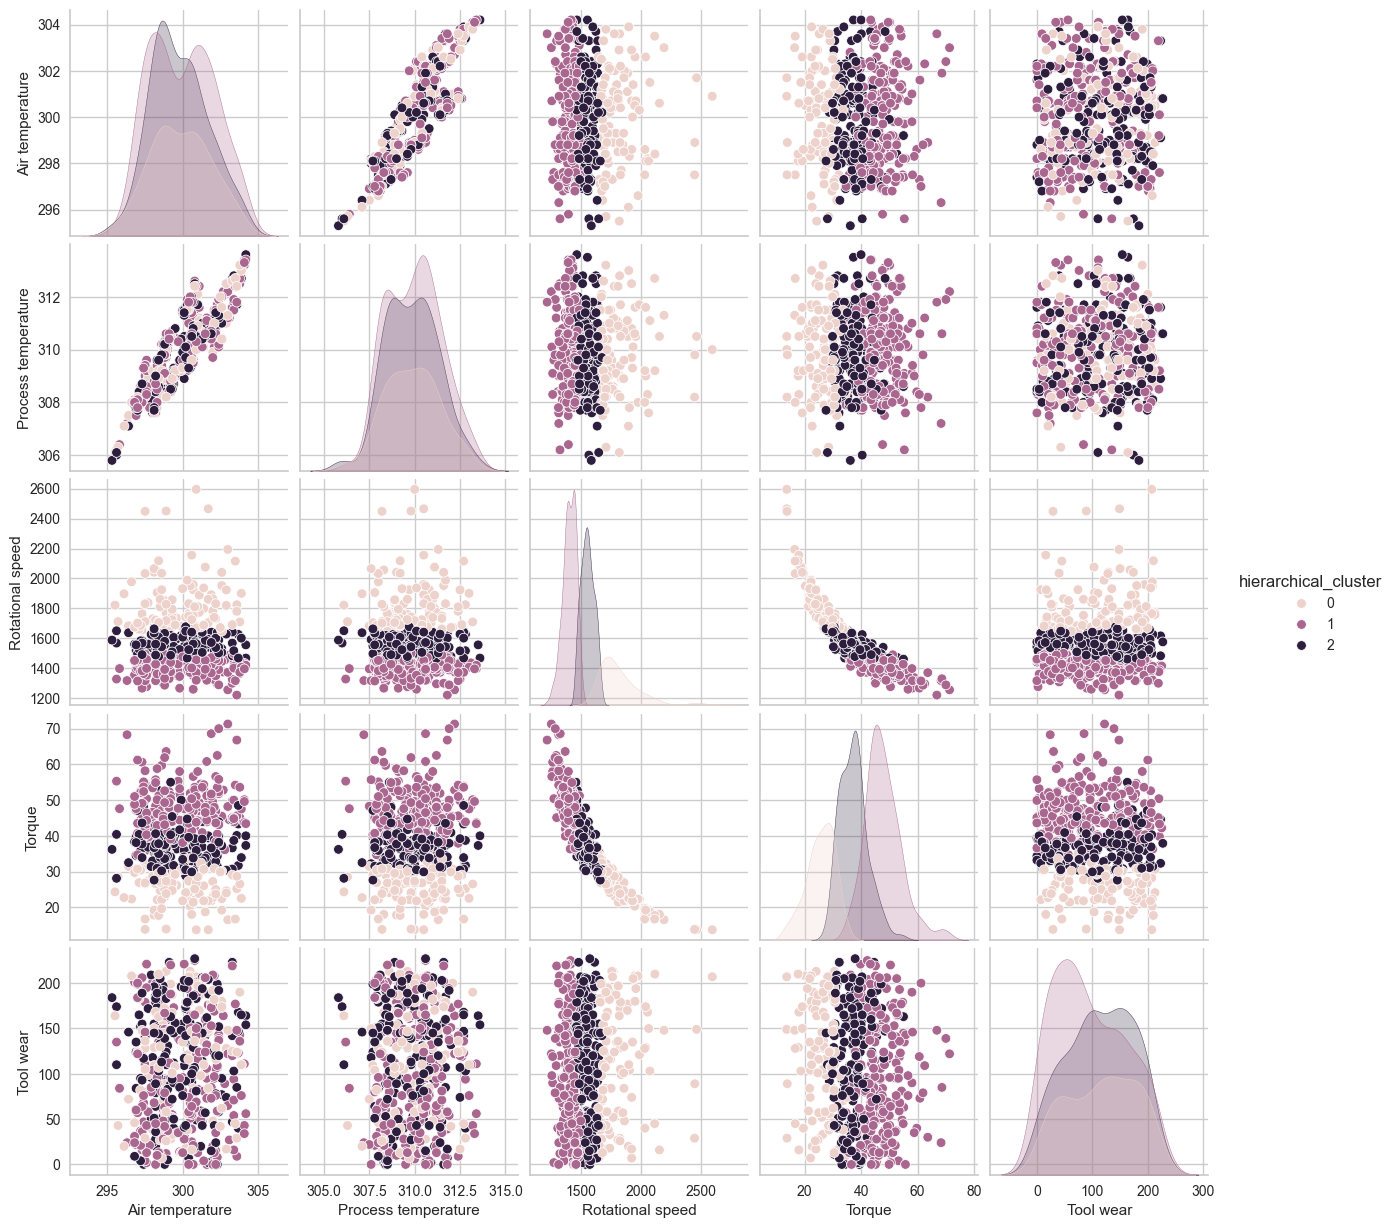

In [453]:
plt.figure(figsize=(10, 8))

# create a pairplot of the data
sns.pairplot(df.sample(frac=0.05), hue="hierarchical_cluster", vars=["Air temperature", "Process temperature", "Rotational speed", "Torque", "Tool wear"])
plt.show()

In [454]:
#silhouette coefficient
score = silhouette_score(X, df["hierarchical_cluster"])

print(f"Silhouette Coefficient: {score:.3f}")

Silhouette Coefficient: 0.337


Supervised Learning

Preparing train-test split

In [455]:
model_performance = pd.DataFrame(columns=['Accuracy', 'Precision',
                                          'Recall', 'F1-Score', 'Training time',
                                          'Prediction time'])

def log_scores(model_name, y_test, y_predictions):
    accuracy = accuracy_score(y_test, y_predictions)
    precision = precision_score(y_test, y_predictions, average='weighted')
    recall = recall_score(y_test, y_predictions, average='weighted')
    precision = precision_score(y_test, y_predictions, average='weighted')
    f1 = f1_score(y_test, y_predictions, average='weighted')

    model_performance.loc[model_name] = [accuracy, precision, recall, f1,
                                       end_train-start, end_predict-end_train]

In [456]:
X=df[['Air temperature', 'Process temperature', 'Rotational speed',
       'Torque', 'Tool wear']]
y=df['Target']

In [457]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42,stratify=y)

To solve imbalanced training data we made oversample it's better than smote


In [458]:
oversample = SVMSMOTE(random_state = 42)

X_train, y_train = oversample.fit_resample(X_train, y_train)

Descision Tree Classifier

In [459]:
start = time.time()
model = DecisionTreeClassifier(max_depth = 8).fit(X_train, y_train)
end_train = time.time()
y_predictions = model.predict(X_test)
end_predict = time.time()

# evaluate the model
log_scores("Decision Tree", y_test, y_predictions)
print("Decision Tree\n" + classification_report(y_test, y_predictions))


Decision Tree
              precision    recall  f1-score   support

       False       0.99      0.97      0.98      2888
        True       0.39      0.63      0.48        94

    accuracy                           0.96      2982
   macro avg       0.69      0.80      0.73      2982
weighted avg       0.97      0.96      0.96      2982



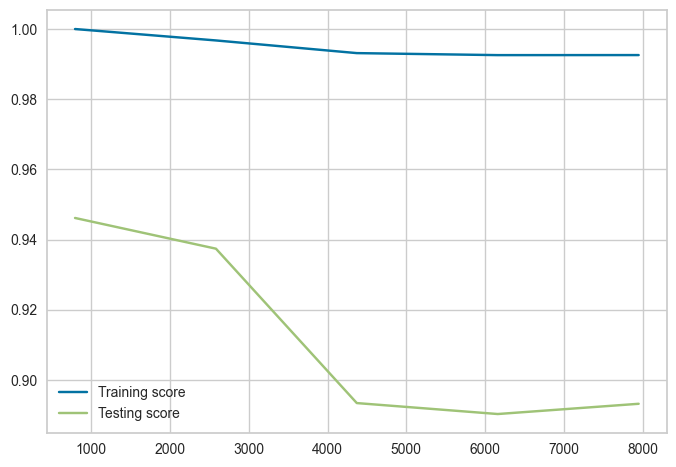

In [460]:
train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=5)

# plot the learning curve
plt.plot(train_sizes, train_scores.mean(axis=1), label='Training score')
plt.plot(train_sizes, test_scores .mean(axis=1), label='Testing score')
plt.legend(loc='best')
plt.show()

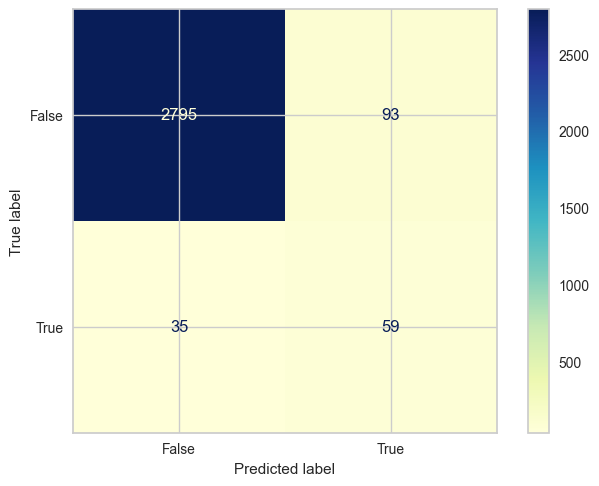

In [461]:
ConfusionMatrixDisplay.from_predictions(y_test, y_predictions, cmap=plt.cm.YlGnBu)  

In [462]:
from sklearn.tree import export_text

rules = export_text(model)

print(rules)

|--- feature_2 <= 1377.50
|   |--- feature_4 <= 183.50
|   |   |--- feature_0 <= 300.70
|   |   |   |--- feature_3 <= 62.14
|   |   |   |   |--- feature_3 <= 57.21
|   |   |   |   |   |--- feature_2 <= 1376.50
|   |   |   |   |   |   |--- class: False
|   |   |   |   |   |--- feature_2 >  1376.50
|   |   |   |   |   |   |--- feature_0 <= 300.42
|   |   |   |   |   |   |   |--- class: False
|   |   |   |   |   |   |--- feature_0 >  300.42
|   |   |   |   |   |   |   |--- feature_3 <= 51.51
|   |   |   |   |   |   |   |   |--- class: False
|   |   |   |   |   |   |   |--- feature_3 >  51.51
|   |   |   |   |   |   |   |   |--- class: True
|   |   |   |   |--- feature_3 >  57.21
|   |   |   |   |   |--- feature_2 <= 1367.50
|   |   |   |   |   |   |--- feature_0 <= 299.85
|   |   |   |   |   |   |   |--- class: False
|   |   |   |   |   |   |--- feature_0 >  299.85
|   |   |   |   |   |   |   |--- feature_1 <= 310.22
|   |   |   |   |   |   |   |   |--- class: False
|   |   |   |   |   | 

k-NN (K-nearest neighbors) Model


In [463]:
knn = KNeighborsClassifier()

param_grid = {'n_neighbors': range(2, 20)}

grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train, y_train)

print(grid_search.best_params_)

{'n_neighbors': 2}


In [464]:
start = time.time()
model = KNeighborsClassifier(n_neighbors=2).fit(X_train, y_train)
end_train = time.time()
y_predictions = model.predict(X_test) 
end_predict = time.time()

log_scores("k-NN", y_test, y_predictions)

In [465]:
print("k-NN Model\n" + classification_report(y_test, y_predictions))


k-NN Model
              precision    recall  f1-score   support

       False       0.98      0.96      0.97      2888
        True       0.26      0.43      0.33        94

    accuracy                           0.94      2982
   macro avg       0.62      0.69      0.65      2982
weighted avg       0.96      0.94      0.95      2982



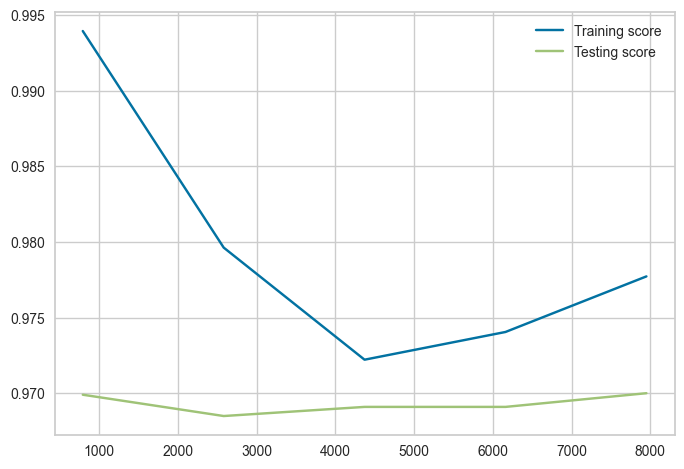

In [466]:
train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=5)

plt.plot(train_sizes, train_scores.mean(axis=1), label='Training score')
plt.plot(train_sizes, test_scores .mean(axis=1), label='Testing score')
plt.legend(loc='best')
plt.show()

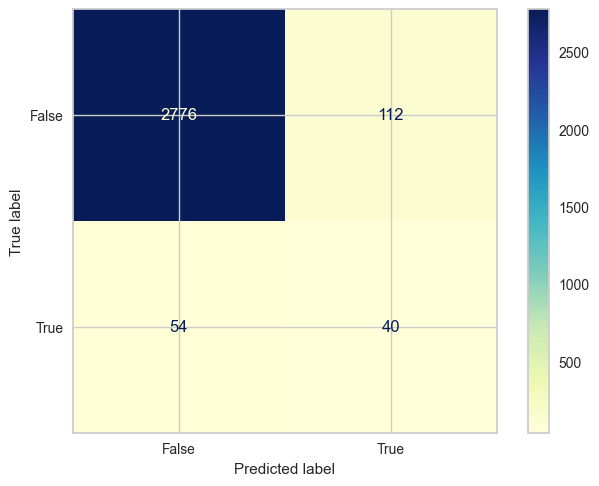

In [467]:
ConfusionMatrixDisplay.from_predictions(y_test, y_predictions, cmap=plt.cm.YlGnBu)  

Logistic Regression Model


In [468]:
start = time.time()
model = LogisticRegression().fit(X_train, y_train)
end_train = time.time()
y_predictions = model.predict(X_test)
end_predict = time.time()

log_scores("Logistic Regression", y_test, y_predictions)

In [469]:
print("Logistic Regression\n" + classification_report(y_test, y_predictions))

Logistic Regression
              precision    recall  f1-score   support

       False       0.99      0.88      0.93      2888
        True       0.15      0.66      0.24        94

    accuracy                           0.87      2982
   macro avg       0.57      0.77      0.58      2982
weighted avg       0.96      0.87      0.91      2982



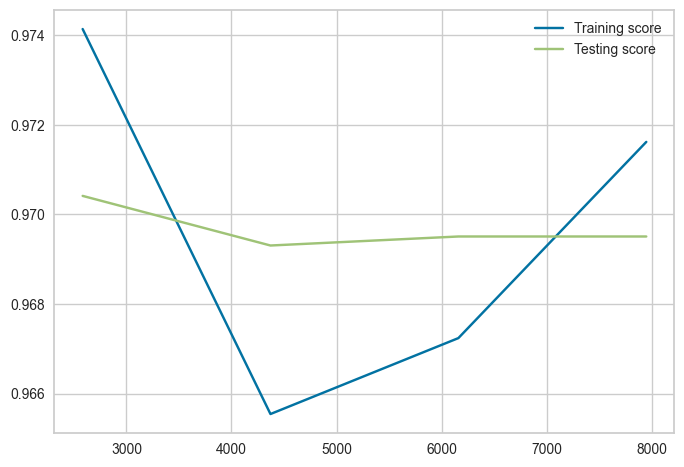

In [470]:
train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=5)

plt.plot(train_sizes, train_scores.mean(axis=1), label='Training score')
plt.plot(train_sizes, test_scores .mean(axis=1), label='Testing score')
plt.legend(loc='best')
plt.show()

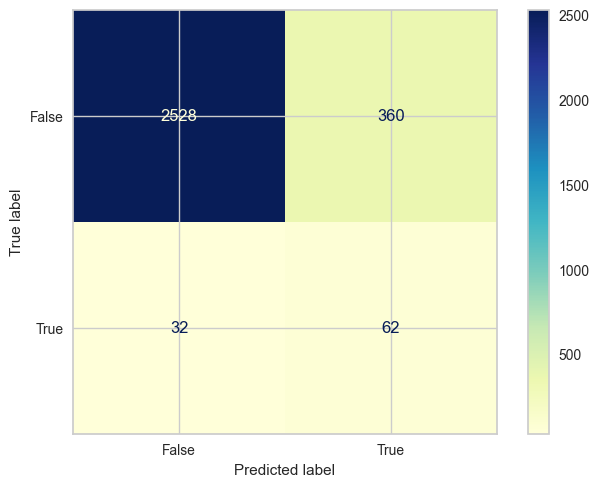

In [471]:
ConfusionMatrixDisplay.from_predictions(y_test, y_predictions, cmap=plt.cm.YlGnBu)  

Random Forest Model

In [472]:
start = time.time()
model = RandomForestClassifier(n_estimators=100, n_jobs=-1,
                               random_state=0, bootstrap=True).fit(X_train, y_train)
end_train = time.time()
y_predictions = model.predict(X_test)
end_predict = time.time()

log_scores("Random Forest", y_test, y_predictions)

In [473]:
print("Random Forest Model\n" + classification_report(y_test, y_predictions))

Random Forest Model
              precision    recall  f1-score   support

       False       0.99      0.98      0.99      2888
        True       0.55      0.70      0.62        94

    accuracy                           0.97      2982
   macro avg       0.77      0.84      0.80      2982
weighted avg       0.98      0.97      0.97      2982



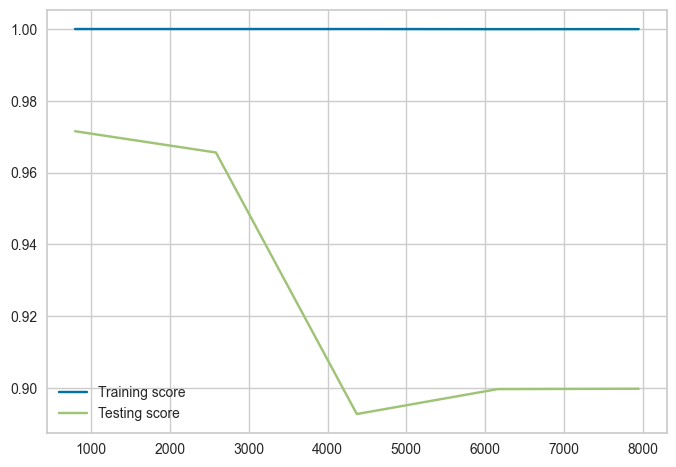

In [474]:
train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=5)

plt.plot(train_sizes, train_scores.mean(axis=1), label='Training score')
plt.plot(train_sizes, test_scores .mean(axis=1), label='Testing score')
plt.legend(loc='best')
plt.show()

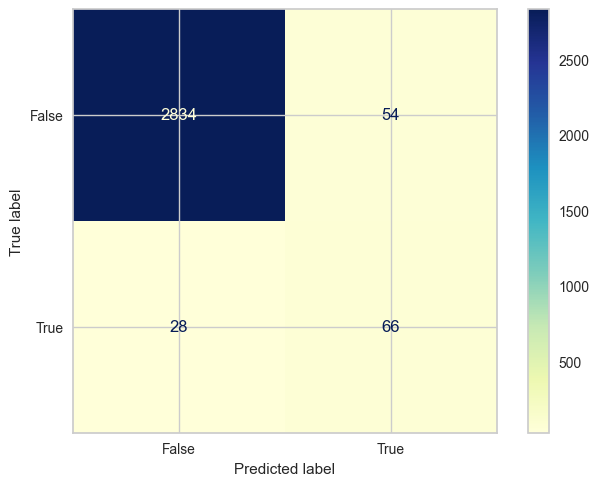

In [475]:
ConfusionMatrixDisplay.from_predictions(y_test, y_predictions, cmap=plt.cm.YlGnBu)  

Gradient Boosting Model


In [476]:
start = time.time()
model = GradientBoostingClassifier().fit(X_train, y_train)
end_train = time.time()
y_predictions = model.predict(X_test)
end_predict = time.time()

log_scores("Gradient Boosting", y_test, y_predictions)

In [477]:
print("Gradient Boosting\n" + classification_report(y_test, y_predictions))

Gradient Boosting
              precision    recall  f1-score   support

       False       0.99      0.96      0.98      2888
        True       0.41      0.78      0.53        94

    accuracy                           0.96      2982
   macro avg       0.70      0.87      0.76      2982
weighted avg       0.97      0.96      0.96      2982



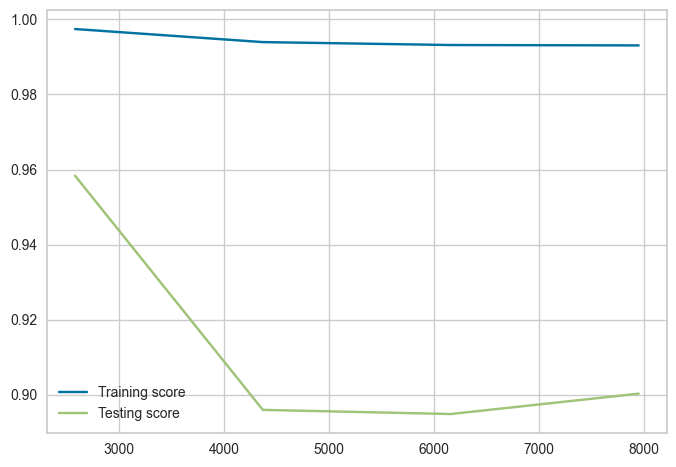

In [478]:
train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=5)

plt.plot(train_sizes, train_scores.mean(axis=1), label='Training score')
plt.plot(train_sizes, test_scores .mean(axis=1), label='Testing score')
plt.legend(loc='best')
plt.show()

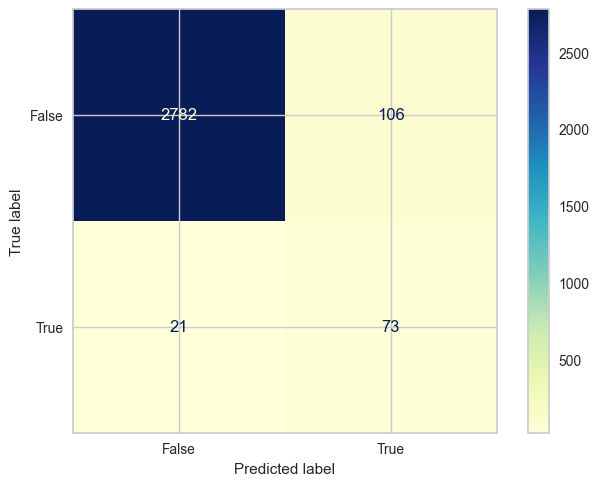

In [479]:
ConfusionMatrixDisplay.from_predictions(y_test, y_predictions, cmap=plt.cm.YlGnBu) 

XGBOOST Model

In [480]:
start = time.time()
model = xgb.XGBClassifier().fit(X_train, y_train)
end_train = time.time()
y_predictions = model.predict(X_test)
end_predict = time.time()

log_scores("XGBOOST Model", y_test, y_predictions)

In [481]:
print("XGBOOST Model\n" + classification_report(y_test, y_predictions))

XGBOOST Model
              precision    recall  f1-score   support

       False       0.99      0.98      0.99      2888
        True       0.59      0.71      0.65        94

    accuracy                           0.98      2982
   macro avg       0.79      0.85      0.82      2982
weighted avg       0.98      0.98      0.98      2982



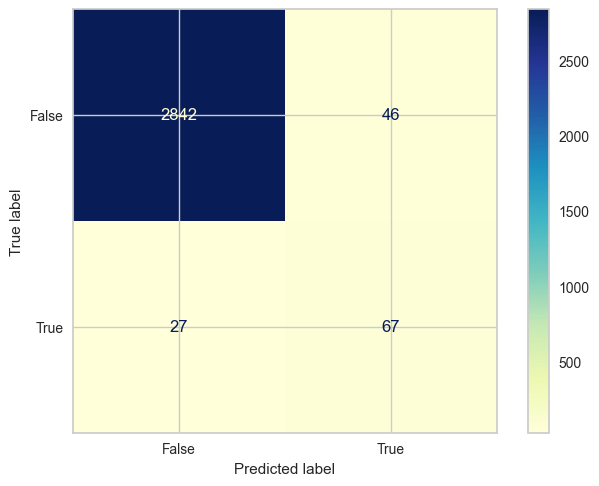

In [482]:
ConfusionMatrixDisplay.from_predictions(y_test, y_predictions, cmap=plt.cm.YlGnBu)  

SVC SUPPORT VECTOR CLASSIFIER

In [483]:
start = time.time()
model = SVC().fit(X_train, y_train)
end_train = time.time()
y_predictions = model.predict(X_test)
end_predict = time.time()

log_scores("SVC", y_test, y_predictions)

In [484]:
print("SVC\n" + classification_report(y_test, y_predictions))

SVC
              precision    recall  f1-score   support

       False       0.99      0.87      0.93      2888
        True       0.15      0.70      0.25        94

    accuracy                           0.87      2982
   macro avg       0.57      0.79      0.59      2982
weighted avg       0.96      0.87      0.91      2982



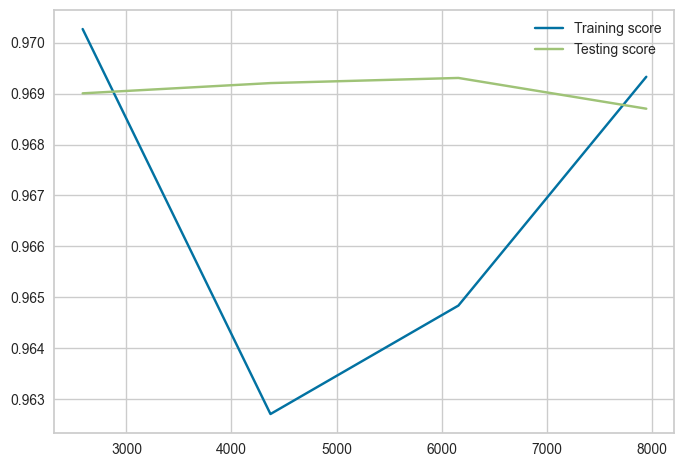

In [485]:
train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=5)

plt.plot(train_sizes, train_scores.mean(axis=1), label='Training score')
plt.plot(train_sizes, test_scores .mean(axis=1), label='Testing score')
plt.legend(loc='best')
plt.show()

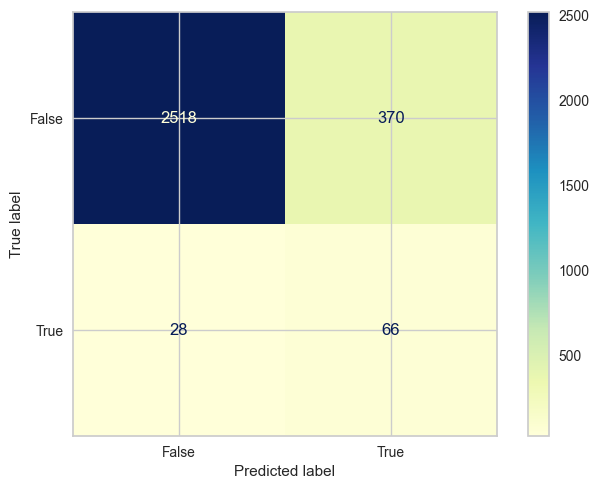

In [486]:
ConfusionMatrixDisplay.from_predictions(y_test, y_predictions, cmap=plt.cm.YlGnBu)  

Gaussian Naive Bayes Model

In [487]:
start = time.time()
model = GaussianNB().fit(X_train, y_train)
end_train = time.time()
y_predictions = model.predict(X_test)
end_predict = time.time()

log_scores("Gaussian Naive Bayes", y_test, y_predictions)

In [488]:
print("Gaussian Naive Bayes\n" + classification_report(y_test, y_predictions))

Gaussian Naive Bayes
              precision    recall  f1-score   support

       False       0.98      0.90      0.94      2888
        True       0.16      0.56      0.25        94

    accuracy                           0.89      2982
   macro avg       0.57      0.73      0.59      2982
weighted avg       0.96      0.89      0.92      2982



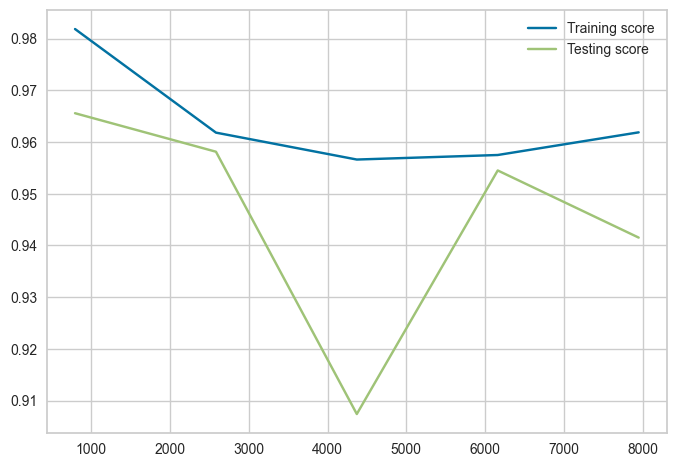

In [489]:
train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=5)

plt.plot(train_sizes, train_scores.mean(axis=1), label='Training score')
plt.plot(train_sizes, test_scores .mean(axis=1), label='Testing score')
plt.legend(loc='best')
plt.show()

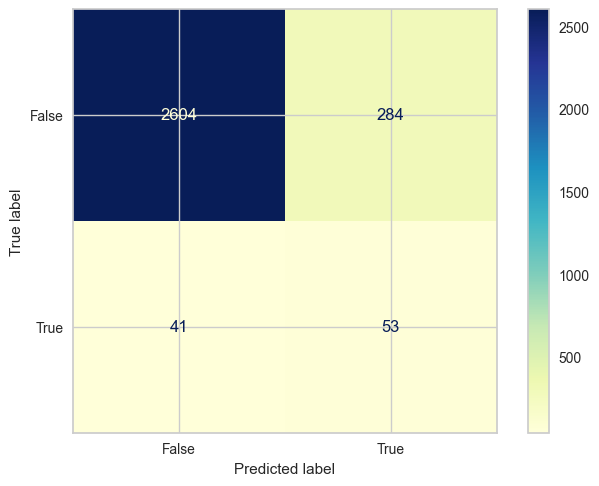

In [490]:
ConfusionMatrixDisplay.from_predictions(y_test, y_predictions, cmap=plt.cm.YlGnBu)  

MLP (Multi-layer Perceptron) Model

In [491]:
start = time.time()
model = MLPClassifier(random_state=1, max_iter=600, learning_rate="invscaling").fit(X_train, y_train)
end_train = time.time()
y_predictions = model.predict(X_test)
end_predict = time.time()

log_scores("Multi-layer Perceptron", y_test, y_predictions)

In [492]:
print("Multi-layer Perceptron\n" + classification_report(y_test, y_predictions))

Multi-layer Perceptron
              precision    recall  f1-score   support

       False       0.99      0.92      0.95      2888
        True       0.22      0.70      0.33        94

    accuracy                           0.91      2982
   macro avg       0.60      0.81      0.64      2982
weighted avg       0.97      0.91      0.93      2982



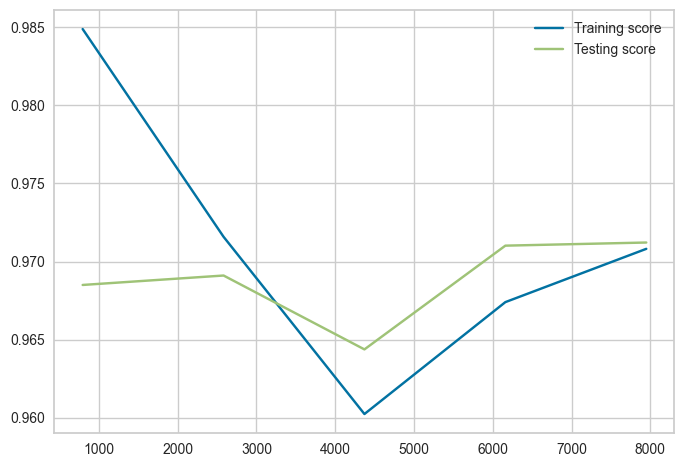

In [493]:
train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=5)

plt.plot(train_sizes, train_scores.mean(axis=1), label='Training score')
plt.plot(train_sizes, test_scores .mean(axis=1), label='Testing score')
plt.legend(loc='best')
plt.show()

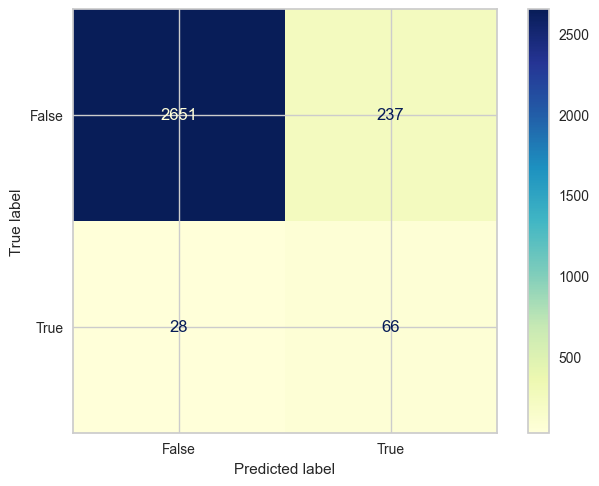

In [494]:
ConfusionMatrixDisplay.from_predictions(y_test, y_predictions, cmap=plt.cm.YlGnBu) 

Evaluation

In [495]:
model_performance


Accuracy  Precision    Recall  F1-Score  \
Decision Tree           0.957076   0.968736  0.957076  0.961918   
k-NN                    0.944333   0.958293  0.944333  0.950613   
Logistic Regression     0.868545   0.961003  0.868545  0.906368   
Random Forest           0.972502   0.976340  0.972502  0.974110   
Gradient Boosting       0.957411   0.974077  0.957411  0.963723   
XGBOOST Model           0.975520   0.978054  0.975520  0.976603   
SVC                     0.866533   0.962598  0.866533  0.905395   
Gaussian Naive Bayes    0.891013   0.958423  0.891013  0.919343   
Multi-layer Perceptron  0.911133   0.965222  0.911133  0.932857   

                        Training time  Prediction time  
Decision Tree                0.085415         0.003997  
k-NN                         0.038170         0.360180  
Logistic Regression          0.203598         0.001999  
Random Forest                0.789798         0.052567  
Gradient Boosting            3.643524         0.007250  
XGBOOST Model                0.253379         0.014552  
SVC                          5.250574         2.278684  
Gaussian Naive Bayes         0.005782         0.000000  
Multi-layer Perceptron       2.904267         0.004997

Saving Model and making Predictions

In [496]:
model = xgb.XGBClassifier()
model.fit(X_train, y_train)

with open('xgb_model.pkl', 'wb') as file:
    pickle.dump(model, file)


In [ ]:
model = RandomForestClassifier(n_estimators=100, n_jobs=-1,
                               random_state=0, bootstrap=True)
model.fit(X_train, y_train)

In [516]:
model.score(X_test, y_test)

0.9725016767270288

[[2834   54]
 [  28   66]]


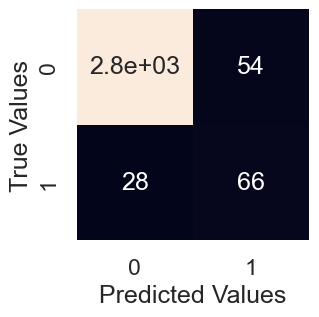

In [546]:
y_pred=model.predict(X_test)

print(confusion_matrix(y_test,y_pred))
sns.set_theme(font_scale=1.5)
fig, ax = plt.subplots(figsize=(3,3))
ax = sns.heatmap(confusion_matrix(y_test, y_pred),
                     annot=True,
                     cbar=False)
plt.xlabel("Predicted Values")
plt.ylabel("True Values")
plt.show()

Cross-val scores

In [527]:
cv_rc=cross_val_score(model,X,y,cv=5,scoring='recall')
print("cross-validation recall" ,np.mean(cv_rc))
cv_acc=cross_val_score(model,X,y,cv=5,scoring='accuracy')
print("cross-validation accruacy ",np.mean(cv_acc))
cv_f1=cross_val_score(model,X,y,cv=5,scoring='f1')
print("cross-validation f1: ",np.mean(cv_f1))
cv_prec=cross_val_score(model,X,y,cv=5,scoring='precision')
print("cross-validation precision: ",np.mean(cv_prec))

cross-validation recall 0.47337429595494107
cross-validation accruacy  0.8997533261977502
cross-validation f1:  0.4272837163045537
cross-validation precision:  0.5970350530045969


In [510]:
#Randomgridsearch CV and model tuning
rand_params = { "n_estimators": np.arange(10, 100, 20),
                       "max_depth": [None, 5, 10], 
                       "min_samples_split": np.arange(5, 20, 5), 
                       "min_samples_leaf": np.arange(1, 10, 2) }
rs_rf = RandomizedSearchCV(model,param_distributions=rand_params,cv=5,verbose=True,
return_train_score=True,n_iter=10,scoring='accuracy')
model_tuned=rs_rf.fit(X_train,y_train)
print('Best hyper parameter:', rs_rf.best_params_)
print("Score after tuning:", model_tuned.score(X_test,y_test))

Fitting 5 folds for each of 10 candidates, totalling 50 fits


Best hyper parameter: {'n_estimators': np.int64(10), 'min_samples_split': np.int64(10), 'min_samples_leaf': np.int64(3), 'max_depth': None}
Score after tuning: 0.9681421864520456


In [497]:
feature_importances = model.feature_importances_

importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print(importance_df)


               Feature  Importance
3               Torque    0.443511
2     Rotational speed    0.308110
4            Tool wear    0.132888
0      Air temperature    0.077486
1  Process temperature    0.038004


In [498]:
#can be used in knn, random forest
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', KNeighborsClassifier(n_neighbors=2))
])

pipeline.fit(X_train, y_train)

predictions_scaled = pipeline.predict(X_test)

log_scores("knn revised", y_test, predictions_scaled)




In [499]:
def predict(air_temperature, process_temperature, rotational_speed, torque, tool_wear, type):

    temp = [{ 'Air temperature':air_temperature,
             'Process temperature':process_temperature, 'Rotational speed':rotational_speed,
             'Torque':torque, 'Tool wear':tool_wear}]

    input_data = pd.DataFrame(temp) 
    prediction = model.predict_proba(input_data)

    classes = ["No failure", "Machine failure"]
    prediction_dict = dict
    for record in prediction:
        prediction_dict = {classes[i] : record[i] for i in range(2)}
    
    maintenance = "No action required"
    if max(prediction_dict, key=prediction_dict.get) != "No failure":
        maintenance = "Need maintenance"

    return prediction_dict, maintenance

# create the user interface (inputs and outputs)
demo = gr.Interface(
    fn=predict,
    inputs=[gr.Slider(100, 3500, label="Air temperature"),
            gr.Slider(100, 3500, label="Process temperature"),
            gr.Slider(100, 3500,label="Rotational speed"),
            gr.Slider(1, 350,label="Torque"),
            gr.Slider(1, 350,label="Tool wear"),
            ],
    outputs=[gr.Label(num_top_classes=2, label="Result"), gr.components.Textbox(label="Action")]
)
demo.launch()

* Running on local URL:  http://127.0.0.1:7889

To create a public link, set `share=True` in `launch()`.


In [500]:
from gradio_client import Client

client = Client("http://127.0.0.1:7887/")
result = client.predict(
		air_temperature=1000,
		process_temperature=100,
		rotational_speed=100,
		torque=1,
		tool_wear=1,
		api_name="/predict"
)
print(result)

Loaded as API: http://127.0.0.1:7887/ ✔
({'label': 'Machine failure', 'confidences': [{'label': 'Machine failure', 'confidence': 0.9990168809890747}, {'label': 'No failure', 'confidence': 0.000983119010925293}]}, 'Need maintenance')
